### Here I make a catalog for Ryan Hickox at Dartmouth. He'd like to help us observe UDGs to measure spec-zs.

### Last update: 2023-04-13

In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

In [2]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress

import astropy.units as u
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord

import pickle

In [3]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)
GALARY = '/tigress/jiaxuanl/public_html/galary/'

In [109]:
### UDG ###
name = 'udg'
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_220726.fits')
fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.1]
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_220726_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

Total angular area [deg2]: 32.70887732960614


In [4]:
### UPG ###
name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

Total angular area [deg2]: 32.36912377009267


#### Only select bright ones, then rank by color

In [5]:
# flag = ((udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0]) > 24.5) & (udg_cat['SB_eff_avg'][:, 0] < 25.5)
flag = (udg_cat['SB_eff_avg'][:, 0] < 25.5)
flag &= ((udg_cat['rhalf_spergel'] + udg_cat['rhalf_spergel_err']) > 3.) # large ones
# flag &= (udg_cat['g-i'] >= 0.6) # only want red ones
# flag &= (udg_cat['g-i'] < 0.6) # only want blue ones

In [6]:
np.sum(flag)

117

In [7]:
cat = udg_cat[flag]

# Check repeatance
lsbg_coord = SkyCoord(cat['ra'], cat['dec'], unit='deg')

dist_mat = lsbg_coord[None, :].separation(lsbg_coord[:, None]).to(u.deg).value
np.fill_diagonal(dist_mat, 100)

if (dist_mat < (2 * u.arcsec).to(u.deg).value).sum() > 0:
    print('Have overlapping objects')
else:
    print('No overlapping objects')

No overlapping objects


In [8]:
# distance to host
lsbg_coord = SkyCoord(cat['ra'], cat['dec'], unit='deg')
host_coord = SkyCoord(cat['host_RA'], cat['host_DEC'], unit='deg')
dist = lsbg_coord.separation(host_coord).to(u.deg).value
dist_vir = dist / cat['host_r_vir_ang'].data

cat['dist_to_host_rvir'] = dist_vir
cat['SB_eff_avg_g'] = cat['SB_eff_avg'][:, 0]

cat.sort('g-i')

In [9]:
flag = (cat['dec'] < 20) # (udg_cat['ra'] >= 10 * 15) & (udg_cat['ra'] <= 20 * 15) & 
flag &= (cat['g-i'] < 0.6) # nothing too red. Otherwise it will be hard to get redshift
cat = cat[flag]

In [10]:
from astropy.cosmology import Planck15
# Calculate V-band abs mag according to Lupton 2005: https://classic.sdss.org/dr7/algorithms/sdssUBVRITransform.html#Lupton2005
V = cat['mag'][:, 0] - 0.5784 * \
    (cat['mag'][:, 0] - cat['mag'][:, 1]) - 0.0038
V_abs = V - 25 - 5 * np.log10(cat['host_ang_diam_dist'].data *
                              (1 + cat['host_z'].data)**2)
# The criterion for quenching is from Carlsten+22. The original intercept is -0.23. I think 0.28 works better for our sample.
quenched = (cat['g-i'] > (-0.067 * V_abs - 0.23))
cat['quenched'] = quenched

In [118]:
output_cat = cat[['viz-id', 'ra', 'dec', 'rhalf_spergel', 'SB_eff_avg_g', 
                  'host_z', 'host_stellar_mass', 'dist_to_host_rvir', 'host_RA', 'host_DEC', 'g-i', 'quenched']]
output_cat.rename_column('rhalf_spergel', 'rhalf_arcsec')
output_cat.sort('SB_eff_avg_g')
output_cat

viz-id,ra,dec,rhalf_arcsec,SB_eff_avg_g,host_z,host_stellar_mass,dist_to_host_rvir,host_RA,host_DEC,g-i,quenched
,deg,deg,arcsec,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool
3805,151.1125408,1.8948408,3.6067294255409994,23.308638038810717,0.030993763357400894,10.683559745082484,0.7998688404269608,151.13947296455328,1.7877533343766783,0.10969507764885929,False
4144,31.8970727,-4.0439644,6.3241135493617335,23.346930921756496,0.03880023583769798,10.261992781886683,0.8810568301653664,31.8981616276332,-4.109705621306714,0.4662759608983885,False
27138,129.6172269,-2.0361118,4.5248061812148315,23.488564219435272,0.03919384256005287,10.941068976649866,0.9541639738281797,129.75536183317658,-1.9539365674169382,0.4210062541386294,False
59963,18.7058033,1.8020719,3.0108099869050107,23.788430198041297,0.03471063822507858,11.001523345241175,0.24734936161989465,18.660658838183835,1.8294761295928061,0.2955895987354898,False
42044,217.0244677,-1.6665135,5.494245737324448,23.79301559290445,0.030484382063150406,10.274616568812952,0.2122342046346625,217.04180372160715,-1.6768087901870683,0.38386452363109286,False
68047,334.136724,3.5017738,2.8620620900606677,23.92171923999677,0.03853338211774826,11.001868575343714,0.46964307217447715,334.15499546345075,3.4128962305387627,0.2438751693802,False
40344,338.0062275,0.0164106,6.532459926627873,23.928765183638955,0.03894214704632759,11.009867041835413,0.16288995948751278,338.03023482448975,0.0370669306217399,0.588387051153014,False
14681,18.949017,-0.7763651,4.82094740230489,23.94398935510788,0.038293078541755676,10.744828551540003,0.7237129805443552,18.895972555619927,-0.8478539208837471,0.5186291719749713,False


In [119]:
simbad_specz_ids = {4144: 0.04283,
                    42044: 0.03088,
                    40344: 0.03880,
                    14681: 0.00619,
                    9499: 0.024, #[0.024, 0.00079], 
                    75274: 0.015633,
                    81215: 0.16353, 
                    23284: 0.03737,
                    44907: 0.10063,
                    81956: 0.017318,
                    58058: 0.011636,
                    1072: 0.1591,
                    86749: 0.00, # already observed with Meng using LDSS3
                    27138: 0.00, # dont like it
                    }

In [120]:
sorted_specz = np.array(list(simbad_specz_ids.values()))[np.argsort(list(simbad_specz_ids.keys()))]
specz_cat = output_cat[np.in1d(output_cat['viz-id'].data, list(simbad_specz_ids.keys()))]
specz_cat['spec_z'] = [simbad_specz_ids[item] for item in specz_cat['viz-id']]

output_cat = output_cat[~np.in1d(output_cat['viz-id'].data, list(simbad_specz_ids.keys()))]

In [121]:
output_cat

viz-id,ra,dec,rhalf_arcsec,SB_eff_avg_g,host_z,host_stellar_mass,dist_to_host_rvir,host_RA,host_DEC,g-i,quenched
,deg,deg,arcsec,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool
3805,151.1125408,1.8948408,3.6067294255409994,23.308638038810717,0.030993763357400894,10.683559745082484,0.7998688404269608,151.13947296455328,1.7877533343766783,0.10969507764885929,False
59963,18.7058033,1.8020719,3.0108099869050107,23.788430198041297,0.03471063822507858,11.001523345241175,0.24734936161989465,18.660658838183835,1.8294761295928061,0.2955895987354898,False
68047,334.136724,3.5017738,2.8620620900606677,23.92171923999677,0.03853338211774826,11.001868575343714,0.46964307217447715,334.15499546345075,3.4128962305387627,0.2438751693802,False
31639,127.4878328,-1.2739235,5.43158554727518,23.96081608419313,0.039390645921230316,10.43959268880807,0.7275239237459198,127.5487398797155,-1.2701524877867092,0.5853767019671389,False
2965,225.5325325,1.5155803,4.578332349199997,24.112195795104896,0.03512850031256676,11.112083762416468,0.8542251667347637,225.33813869581473,1.6371053856753905,0.5038261613338773,False
78872,188.2742841,0.8168608,3.7815775270551244,24.23227414165203,0.031207069754600525,10.35820612264596,0.39191121860943845,188.27518365318946,0.7783466002094354,0.4724549889358286,False
86760,355.9775462,2.7696841,3.5607185764939637,24.253991369957465,0.0374559685587883,10.81927618337594,0.19435024993365466,355.9903651158272,2.7453934644243927,0.5589767915891098,False
79073,3.3471024,0.7698461,3.782772505918614,24.280743552499793,0.038762882351875305,10.866063445338831,0.3611621791732638,3.3008501896299296,0.7429423363952744,0.5884620144265159,False


Text(0, 0.5, 'Host-z')

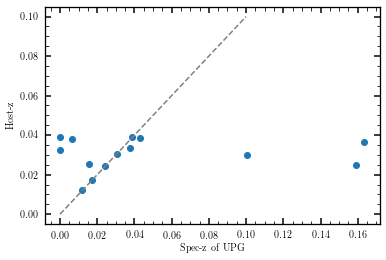

In [122]:
plt.scatter(specz_cat['spec_z'].data, specz_cat['host_z'].data)
x = np.linspace(0, 0.1, 100)
plt.plot(x, x, ls='--', c='gray')

plt.xlabel('Spec-z of UPG')
plt.ylabel('Host-z')

17H - 0H - 3H is observable

2H - 12H

Apr 17: 8h-18h observable

In [123]:
output_cat.write('/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/upg_2023_SALT_blue.fits', 
                 overwrite=True)

In [111]:
output_cat

viz-id,ra,dec,rhalf_spergel,SB_eff_avg_g,host_z,host_stellar_mass,dist_to_host_rvir,host_RA,host_DEC,g-i,quenched
,deg,deg,arcsec,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool
3805,151.1125408,1.8948408,3.6067294255409994,23.308638038810717,0.030993763357400894,10.683559745082484,0.7998688404269608,151.13947296455328,1.7877533343766783,0.10969507764885929,False
59963,18.7058033,1.8020719,3.0108099869050107,23.788430198041297,0.03471063822507858,11.001523345241175,0.24734936161989465,18.660658838183835,1.8294761295928061,0.2955895987354898,False
68047,334.136724,3.5017738,2.8620620900606677,23.92171923999677,0.03853338211774826,11.001868575343714,0.46964307217447715,334.15499546345075,3.4128962305387627,0.2438751693802,False
31639,127.4878328,-1.2739235,5.43158554727518,23.96081608419313,0.039390645921230316,10.43959268880807,0.7275239237459198,127.5487398797155,-1.2701524877867092,0.5853767019671389,False
2965,225.5325325,1.5155803,4.578332349199997,24.112195795104896,0.03512850031256676,11.112083762416468,0.8542251667347637,225.33813869581473,1.6371053856753905,0.5038261613338773,False
78872,188.2742841,0.8168608,3.7815775270551244,24.23227414165203,0.031207069754600525,10.35820612264596,0.39191121860943845,188.27518365318946,0.7783466002094354,0.4724549889358286,False
86760,355.9775462,2.7696841,3.5607185764939637,24.253991369957465,0.0374559685587883,10.81927618337594,0.19435024993365466,355.9903651158272,2.7453934644243927,0.5589767915891098,False
79073,3.3471024,0.7698461,3.782772505918614,24.280743552499793,0.038762882351875305,10.866063445338831,0.3611621791732638,3.3008501896299296,0.7429423363952744,0.5884620144265159,False


In [82]:
# cat['ra_abs'] = cat['ra'] #[ra - 360 if ra > 180 else ra for ra in cat['ra']]
# cat.sort('ra_abs')
# # sort by hour angle

In [112]:
len(cat)

61

In [113]:
obscat = output_cat[['viz-id', 'ra', 'dec', 'rhalf_spergel', 'SB_eff_avg_g']]
# obscat = obscat[(obscat['ra'] > 250) | (obscat['ra'] < 190)]

In [114]:
len(obscat)

47

In [115]:
obscat['exptime'] = 10**(0.4 * (obscat['SB_eff_avg_g'].data - 24.5)) * 0.5

In [71]:
# absra = obscat['ra'] #[ra - 360 if ra > 180 else ra for ra in obscat['ra']]
# obscat = obscat[np.argsort(absra)]

In [116]:
obscat.sort('SB_eff_avg_g')

In [117]:
hstack([obscat[['viz-id', 'ra', 'dec', 'rhalf_spergel', 'SB_eff_avg_g']], 
       ],
      ).write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/upg_2023_SALT_blue.txt', 
    format='ascii', overwrite=True)

In [121]:
320 / 15

21.333333333333332

(array([10.,  0.,  0.,  5.,  6.,  3.,  0.,  0.,  0., 14.]),
 array([ 0.22314016,  2.57400979,  4.92487941,  7.27574904,  9.62661866,
        11.97748829, 14.32835791, 16.67922754, 19.03009716, 21.38096679,
        23.73183641]),
 <BarContainer object of 10 artists>)

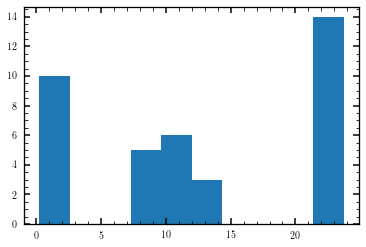

In [73]:
plt.hist(obscat['ra'] / 15)

---

In [94]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

from astropy.coordinates import SkyCoord
from astroplan import FixedTarget
from astroplan import Observer
from pytz import timezone
from astropy.coordinates import EarthLocation
from astroplan.plots import plot_airmass 
observer = Observer.at_site('Southern African Large Telescope', timezone=timezone('US/Eastern'))

In [95]:
obscat

viz-id,ra,dec,rhalf_spergel,SB_eff_avg_g,exptime
,deg,deg,arcsec,,
int64,float64,float64,float64,float64,float64
3805,151.1125408,1.8948408,3.6067294255409994,23.308638038810717,0.16688804218968703
27138,129.6172269,-2.0361118,4.5248061812148315,23.488564219435272,0.19696800769889145
59963,18.7058033,1.8020719,3.0108099869050107,23.788430198041297,0.2596223541179851
68047,334.136724,3.5017738,2.8620620900606677,23.92171923999677,0.2935335184792966
31639,127.4878328,-1.2739235,5.43158554727518,23.96081608419313,0.30429613625185487
2965,225.5325325,1.5155803,4.578332349199997,24.112195795104896,0.3498229697977855
78872,188.2742841,0.8168608,3.7815775270551244,24.23227414165203,0.39073261238080675
86760,355.9775462,2.7696841,3.5607185764939637,24.253991369957465,0.39862685416004223


In [96]:
objs = []
for i in range(len(obscat)):
    coord = SkyCoord(obscat['ra'][i], obscat['dec'][i], unit='deg')
#     obj = FixedTarget(name=str(cat['viz-id'][i]), coord=coord)
    obj = FixedTarget(name=obscat[i]['viz-id'], coord=coord)
    objs.append(obj)

In [97]:
objs[1]

<FixedTarget "27138" at SkyCoord (ICRS): (ra, dec) in deg (129.6172269, -2.0361118)>

In [113]:
# night ends at 9:43

ValueError: year -4713 is out of range

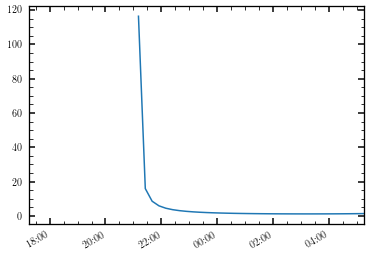

In [99]:
fig, ax = plt.subplots(figsize=(6, 4))
time = Time('2023-11-21 19:00', location=observer.location)
sunset_time = observer.sun_set_time(time, which='nearest')
sunrise_time = observer.sun_rise_time(time, which='nearest')

observe_time = sunset_time + np.linspace(0, 12, 50) * u.hour

plot_airmass(objs[1], observer, observe_time,  
             brightness_shading=True, use_local_tz=False)

In [83]:
colors = ['#9e0142','#d53e4f','#f46d43','#fdae61','#fee08b',
          '#ffffbf','#e6f598','#abdda4','#66c2a5','#3288bd','#5e4fa2',] * 5

Text(0.5, 1.0, 'UPG observation (SALT)')

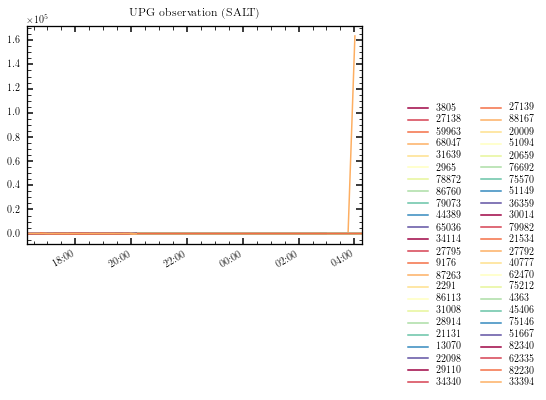

In [100]:
fig, ax = plt.subplots(figsize=(6, 4))
time = Time('2023-09-01 19:00', location=observer.location)
sunset_time = observer.sun_set_time(time, which='nearest')
sunrise_time = observer.sun_rise_time(time, which='nearest')

observe_time = sunset_time + np.linspace(0, 12, 50) * u.hour

for i in range(len(obscat)):
    try:
        plot_airmass(objs[i], observer, observe_time, style_kwargs={'color': colors[i]}, 
                 brightness_shading=True, use_local_tz=False)
    except Exception as e:
        pass
# plot_airmass(objs[1], observer, observe_time)
# plot_airmass(objs[2], observer, observe_time)

plt.axvline(23)
plt.legend(shadow=True, loc=2, ncol=2, bbox_to_anchor=(1.1, 0.7))
plt.title('UPG observation (SALT)')

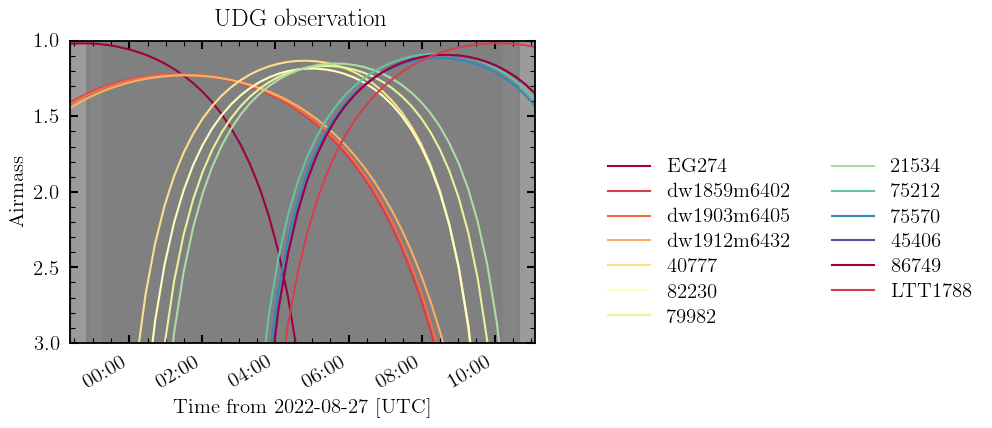

In [408]:
fig, ax = plt.subplots(figsize=(6, 4))
time = Time('2022-08-28 02:00', location=observer.location)
sunset_time = observer.sun_set_time(time, which='nearest')
sunrise_time = observer.sun_rise_time(time, which='nearest')

observe_time = sunset_time + np.linspace(0, (sunrise_time - sunset_time).to(u.hour).value, 50) * u.hour

for i in range(len(obscat)):
    plot_airmass(objs[i], observer, observe_time, style_kwargs={'color': colors[i]}, 
                 brightness_shading=True, use_local_tz=False)
# plot_airmass(objs[1], observer, observe_time)
# plot_airmass(objs[2], observer, observe_time)

plt.axvline(23)
plt.legend(shadow=True, loc=2, ncol=2, bbox_to_anchor=(1.1, 0.7))
plt.title('UDG observation')

plt.savefig('/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/airmass.png', bbox_inches='tight')

In [283]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=15)

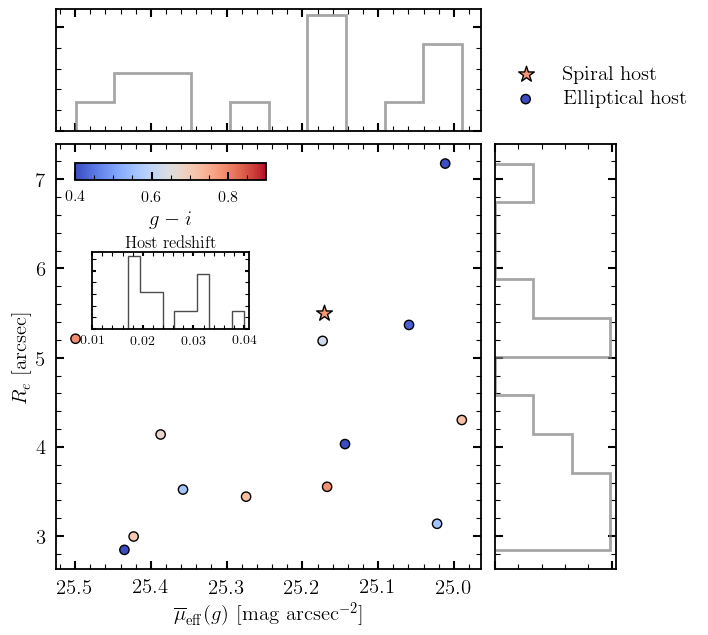

In [284]:
# start with a square Figure
fig = plt.figure(figsize=(7, 7))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histx.set_yticklabels([])
# ax_histx.set_xticklabels([])
ax_histy.tick_params(axis="y", labelleft=False)
ax_histy.set_xticklabels([])

flag = (cat['host_spiral'] == 1)
sct = ax.scatter(
    cat['SB_eff_avg_g'][flag],
    cat['rhalf_spergel'][flag],
    c=(cat['mag'][:, 0] - cat['mag'][:, 2])[flag],
    vmin=0.4, vmax=0.9,
    cmap='coolwarm',
    marker='*',
    edgecolor='k',
    s=140,
    alpha=1,
    label='Spiral host'
    )

sct = ax.scatter(
    cat['SB_eff_avg_g'][~flag],
    cat['rhalf_spergel'][~flag],
    c=(cat['mag'][:, 0] - cat['mag'][:, 2])[~flag],
    vmin=0.4, vmax=0.9,
    cmap='coolwarm',
    edgecolor='k',
    s=45,
    alpha=1,
    label='Elliptical host'
    )

ax.legend(loc='upper right', bbox_to_anchor=(1.55, 1.25))

cax = inset_axes(ax, width="45%", height="4%", 
                 loc='upper left', bbox_to_anchor=(0.02, -0.02, 1, 1),
                 bbox_transform=ax.transAxes) 
plt.colorbar(sct, cax=cax, label='$g-i$',
             orientation='horizontal')
cax.tick_params(labelsize=11.5)

# ax.set_xlim(29, 24)
# ax.set_ylim(1.6, 14)
ax.invert_xaxis()
ax.set_xlabel(r'$\overline{\mu}_{\rm eff}(g)\ [\rm mag\ arcsec^{-2}]$')
ax.set_ylabel(r'$R_e\ [\rm arcsec]$')

ax_histx.hist(cat['SB_eff_avg_g'], lw=2,
              histtype='step', density=True, color='gray', 
              alpha=0.7, label='$g-i > 0.7$')
ax_histy.hist(cat['rhalf_spergel'], lw=2,
              histtype='step', density=True, orientation='horizontal', color='gray', alpha=0.7)
# ax_histy.set_xscale('log')

# show redshift
cax2 = inset_axes(ax, width='37%', height='18%', 
                  loc='upper left', 
                  bbox_to_anchor=(0.06, -0.23, 1, 1),
                  bbox_transform=ax.transAxes)
cax2.hist(cat['host_z'], histtype='step', density=True, color='k', alpha=0.7)
cax2.set_title('Host redshift', fontsize=12, pad=3)
cax2.set_yticklabels([])
cax2.set_xticks([0.01, 0.02, 0.03, 0.04])
cax2.tick_params(axis='both', which='both', length=3, labelsize=10, pad=4)

# plt.savefig('/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/sample_summary.png')

##### Write to Tex

In [99]:
tex_table = hstack([selected_cat[['viz-id', 'ra', 'dec']], 
        Column(data=selected_cat['rhalf_spergel'] * 0.168, name=r'$R_e$'),
        Column(data=selected_cat['SB_eff_avg'][:, 0], name=r'$\overline{\mu}_e(g)$'), 
        Column(data=selected_cat['mag'][:, 0], name=r'$g$'),
        Column(data=selected_cat['mag'][:, 0] - selected_cat['mag'][:, 2], name=r'$g-i$'),
        Column(data=selected_cat['host_z'], name=r'$z_{\mathrm{host}}$'),
        Column(data=selected_cat['dist_to_host_rvir'], name=r'$D_{\rm host}$'),
        Column(data=['S' if t == 1 else 'E' for t in selected_cat['host_spiral']], name='Host type')],
      )
tex_table.rename_column('viz-id', 'ID')
coords = SkyCoord(selected_cat['ra'], selected_cat['dec'], unit='deg')
tex_table['ra'] = (coords.ra / 15).to_string(sep=':', precision=0, fields=3)
tex_table['ra'] = ['0' + t if len(t) == 7 else t for t in tex_table['ra']]
tex_table['dec'] = np.array([f'+{t:.4f}' if t > 0 else f'{t:.4f}' for t in tex_table['dec']])
tex_table.rename_column('ra', 'R.A.')
tex_table.rename_column('dec', 'Dec.')

tex_table[r'$R_e$'] = [f'{t:.2f}' for t in tex_table[r'$R_e$']]
tex_table[r'$g$'] = [f'{t:.2f}' for t in tex_table[r'$g$']]
tex_table[r'$g-i$'] = [f'{t:.2f}' for t in tex_table[r'$g-i$']]
tex_table[r'$\overline{\mu}_e(g)$'] = [f'{t:.2f}' for t in tex_table[r'$\overline{\mu}_e(g)$']]
tex_table[r'$z_{\mathrm{host}}$'] = [f'{t:.4f}' for t in tex_table[r'$z_{\mathrm{host}}$']]
tex_table[r'$D_{\rm host}$'] = [f'{t:.2f}' for t in tex_table[r'$D_{\rm host}$']]

In [100]:
from astropy.io import ascii

In [101]:
selected_id

array([75619, 27795, 86113, 67181, 69381, 65780, 29808, 79982, 30269,
       14216, 81835, 21112, 85963, 73208, 75450])

In [102]:
ascii.write(tex_table, 
            Writer=ascii.Latex, 
               latexdict={'preamble': r'\begin{center}',
                       'tablefoot': r'\end{center}',
                       'tabletype': 'table*',
                          'units': {r'$R_e$': '(arcsec)', 
                                    r'$\overline{\mu_e}(g)$': r'(mag arcsec$^{-2}$)',
                                    r'$g$': '(mag)',
                                    r'$g-i$': '(mag)',
                                    r'$D_{\rm host}$': "($R_{\mathrm{vir}}$)"}
                         })

\begin{table*}
\begin{center}
\begin{tabular}{cccccccccc}
ID & R.A. & Dec. & $R_e$ & $\overline{\mu}_e(g)$ & $g$ & $g-i$ & $z_{\mathrm{host}}$ & $D_{\rm host}$ & Host type \\
 &  &  & (arcsec) &  & (mag) & (mag) &  & ($R_{\mathrm{vir}}$) &  \\
75619 & 01:07:24 & -0.6802 & 4.56 & 24.57 & 19.27 & 0.83 & 0.0177 & 0.35 & E \\
27795 & 22:56:25 & -1.2076 & 13.07 & 24.58 & 17.00 & 0.53 & 0.0103 & 0.87 & S \\
86113 & 23:30:43 & +0.2328 & 6.17 & 24.65 & 18.70 & 0.56 & 0.0172 & 0.50 & E \\
67181 & 23:21:26 & +1.8713 & 9.87 & 24.71 & 17.75 & 0.71 & 0.0296 & 0.87 & E \\
69381 & 01:56:29 & -4.5307 & 4.72 & 25.05 & 19.68 & 0.87 & 0.0177 & 0.20 & S \\
65780 & 02:23:01 & -1.8268 & 4.50 & 25.09 & 19.83 & 0.77 & 0.0194 & 0.52 & S \\
29808 & 01:07:27 & -0.6829 & 8.17 & 25.10 & 18.54 & 0.93 & 0.0177 & 0.39 & E \\
79982 & 23:05:00 & +1.8339 & 6.96 & 25.12 & 18.92 & 0.48 & 0.0171 & 0.86 & E \\
30269 & 01:03:30 & -0.6638 & 5.20 & 25.17 & 19.59 & 0.93 & 0.0179 & 0.85 & E \\
14216 & 01:55:50 & -2.5690 & 5.04 &

In [103]:
gal1 = selected_cat[selected_cat['viz-id'] == 75619]

In [104]:
gal2 = selected_cat[selected_cat['viz-id'] == 29808]

In [105]:
gal1_coord = SkyCoord(gal1['ra'], gal1['dec'], unit='deg')
gal2_coord = SkyCoord(gal2['ra'], gal2['dec'], unit='deg')

In [106]:
gal1_coord.separation(gal2_coord)

<Angle [0.01149488] deg>

In [ ]:
41.4

In [110]:
gal1['host_ang_diam_dist'].data * 41.4 / 206265 * 1000

array([15.38789361])

In [114]:
(13*u.hourangle + 2 * u.arcmin + 16 * u.arcsec).to(u.hourangle).to(u.deg)

<Quantity 195.03777778 deg>

In [116]:
(13 + 2 / 60 + 16 / 3600) * 15

195.56666666666666

In [115]:
(28 * u.deg + 57 * u.arcmin + 17 * u.arcsec).to(u.deg)

<Quantity 28.95472222 deg>

##### Exp time

In [122]:
def calc_exp(SB):
    return 10**(0.4 * (SB - 24.5)) * (10 / 6.5)**2 * (0.3/0.2) * 20 * u.min

$$t_{LDSS3} / t_{LRIS} = (D_{m} / D_{k})^{-2} \cdot (\epsilon_{m} / \epsilon_{k})^{-1} \cdot 10^{0.4 (\mu - 24.5)}$$

$$t_{LDSS3} / t_{LRIS} = (6.5 / 10)^{-2} \cdot (0.1 / 0.3)^{-1} \cdot 10^{0.4 (\mu - 24.5)}$$

In [123]:
calc_exp(24.5).to(u.hour)

<Quantity 1.18343195 h>

In [151]:
calc_exp(25.5).to(u.hour)

<Quantity 2.97264666 h>

In [158]:
(selected_cat['g-i'] < 0.75).sum()

5

In [153]:
exptime = calc_exp(selected_cat['SB_eff_avg_g']).to(u.hour)
exptime[selected_cat['g-i'] < 0.75] = 0.5 * u.hour

In [154]:
exptime

<Quantity [1.25678179, 0.5       , 0.5       , 0.5       , 1.96054604,
           2.04492744, 2.05142035, 0.5       , 2.18646428, 0.5       ,
           2.31985537, 2.50269111, 2.69731946, 2.71176347, 2.79421843] h>

In [155]:
exptime.sum()

<Quantity 25.02598773 h>

In [149]:
np.array([3968, 3933]) * (1 + 0.04)

array([4126.72, 4090.32])

In [150]:
10800 / 3600

3.0

In [125]:
300000 / 450

666.6666666666666

In [128]:
1 / 509 * 300000 / 2.355

250.27217098594718

In [129]:
1900 / 5

380.0

In [135]:
R = 4100 * 0.75 / 5
300000 / R / 2.355

207.13582932007665

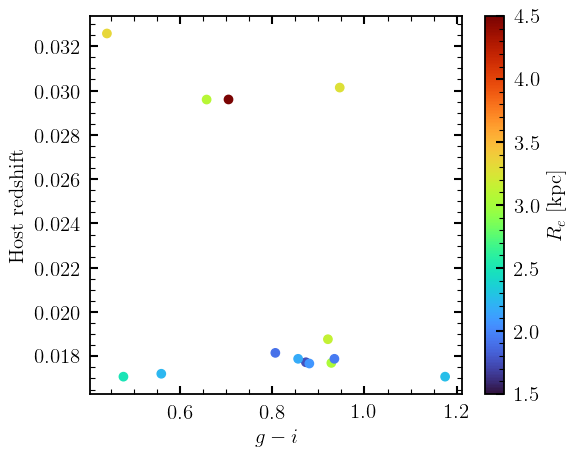

In [273]:
plt.scatter(cat['mag'][:, 0] - cat['mag'][:, 2], 
            cat['host_z'], 
            c=cat['rhalf_circularized_phys'], vmin=1.5, vmax=4.5)
plt.xlabel('$g-i$')
plt.ylabel('Host redshift')
plt.colorbar(label='$R_e$ [kpc]')

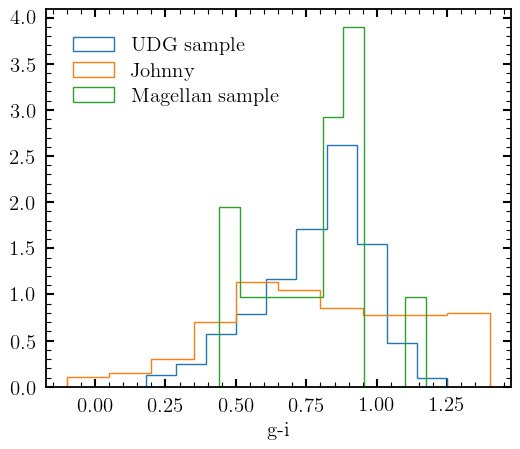

In [274]:
johnny = Table.read('./Catalog/Greco_S18A_lsbg.fits')
plt.hist(udg_cat['mag'][:, 0] - udg_cat['mag'][:, 2], histtype='step', density=True, label='UDG sample')
plt.hist(johnny['g-i'], histtype='step', density=True, label='Johnny')
plt.hist(cat['mag'][:, 0] - cat['mag'][:, 2], density=True, histtype='step', label='Magellan sample')
plt.xlabel('g-i')
plt.legend(loc='upper left')

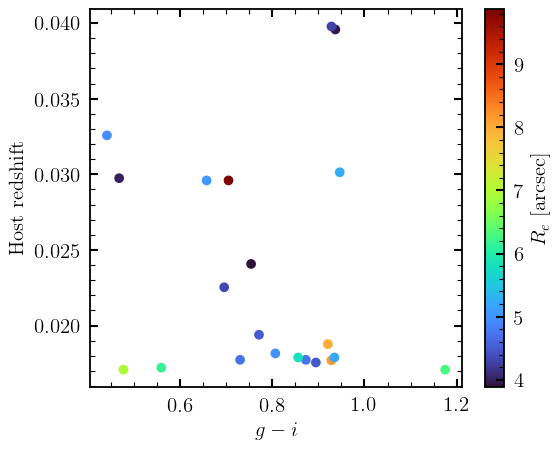

In [245]:
plt.scatter(cat['mag'][:, 0] - cat['mag'][:, 2], 
            cat['host_z'], 
            c=cat['rhalf_spergel'] * 0.168)
plt.xlabel('$g-i$')
plt.ylabel('Host redshift')
plt.colorbar(label='$R_e$ [arcsec]')

In [196]:
hstack([cat[['viz-id', 'ra', 'dec']], 
        Column(data=np.round(cat['rhalf_spergel'] * 0.168, 2), name='rhalf_'),
        Column(data=np.round(cat['SB_eff_avg'][:, 0], 2), name='SB_eff_avg_g'), 
        Column(data=np.round(cat['mag'][:, 0], 2), name='g_mag'),
        Column(data=np.round(cat['mag'][:, 0] - cat['mag'][:, 2], 2), name='g-i'),
       Column(data=np.round(cat['dist_to_host_rvir'], 2), name='dist2host_rvir')]
      ).write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/udg_cat_latex.tex', 
    format='ascii.latex')